Kernelized Support Vector Machines (SVMs)
===

SVMs are an extension to Linear SVMs that allow for more complex models than hyperplanes in the input space.

Linear models can be quite limiting in low-dimensional spaces, as lines and hyperplanes have limited flexibility.  One way to make a linear model more flexible is by adding more features--e.g. adding interactions or polynomials of the input features.

Here is an example two-class classification dataset in which classes are not linearly separable

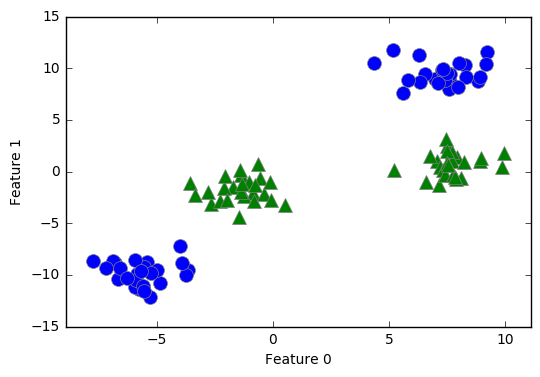

In [3]:
%matplotlib inline
import sklearn
import mglearn
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

A linear model for classification can only separate points using a line.

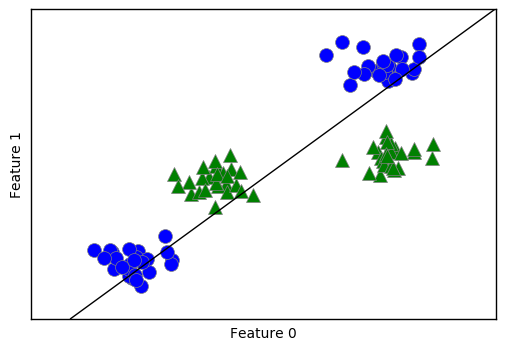

In [5]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

By expanding the set of input features, say by adding `feature1 ** 2`, we no longer represent each feature as a two-dimensional point (`feature0`, `feature1`), we now represent it as a three-dimensional point (`feature0`, `feature1`, `feature1 ** 2`).

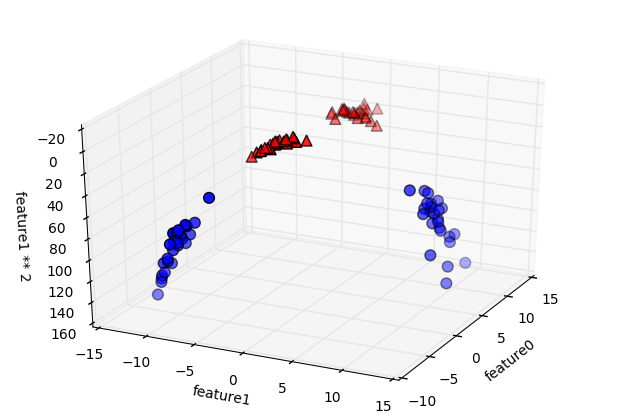

In [6]:
import numpy as np

X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d

figure = plt.figure()

ax = Axes3D(figure, elev=-152, azim=-26)

mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

In the new representation of the data, it is now possible to separate the two classes using a linear model, a plane in three dimensions.

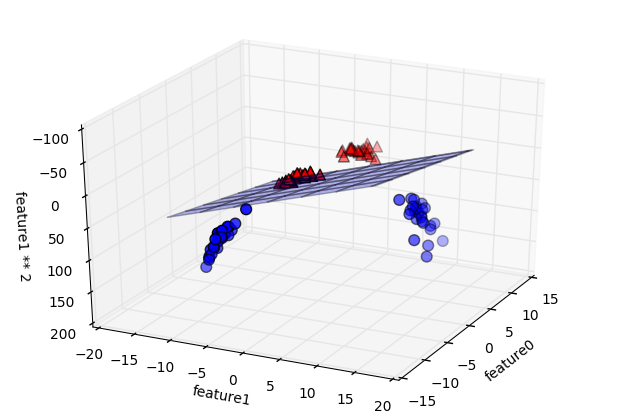

In [7]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

figure = plt.figure()

ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]

ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)

ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

The linear SVM model is not actually linear anymore.  It is more of an ellipse.

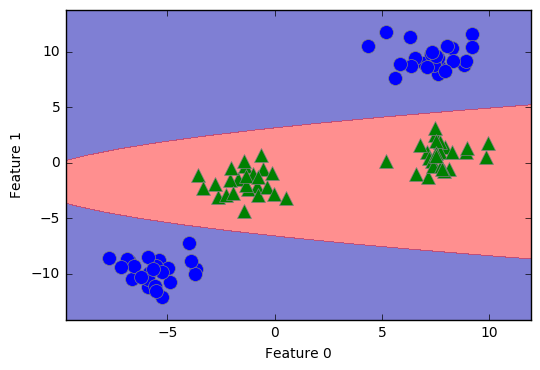

In [8]:
ZZ = YY ** 2

dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

**The kernel trick**

Adding non-linear features to the representation of our data can make linear models more powerful; however, we often don't know which features to add, and adding many features may be computationally expensive.  This is known as the kernel trick.

The kernel trick works by computing the distance (the scalar products) of the data points for the expanded feature representation without ever actually computing the expansion.

There are two ways to map your data into a higher-dimensional space that are common to SVMs:
  - the polynomial kernel, which computes all possible polynomials up to a certain degree of the original features (e.g. `feature1 ** 2 * feature2 ** 5`)
  - the radial basis function (RBF) kernel/"Gaussian" kernel, which considers all possible polynomials of all degrees, but the importance of the features decreases for higher degrees
  
**Tuning SVM parameters**

Gamma - controls the width of the Gaussian kernel, determines the scale of what it means for points to be close together

C - regularization parameter, similar to linear models, limits the importance of each point (their `dual_coef_`)

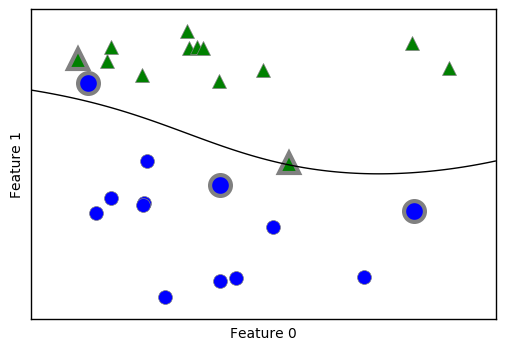

In [9]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()

svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

mglearn.plots.plot_2d_separator(svm, X, eps=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# plot support vectors
sv = svm.support_vectors_

# class labels given by sign of dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0

mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

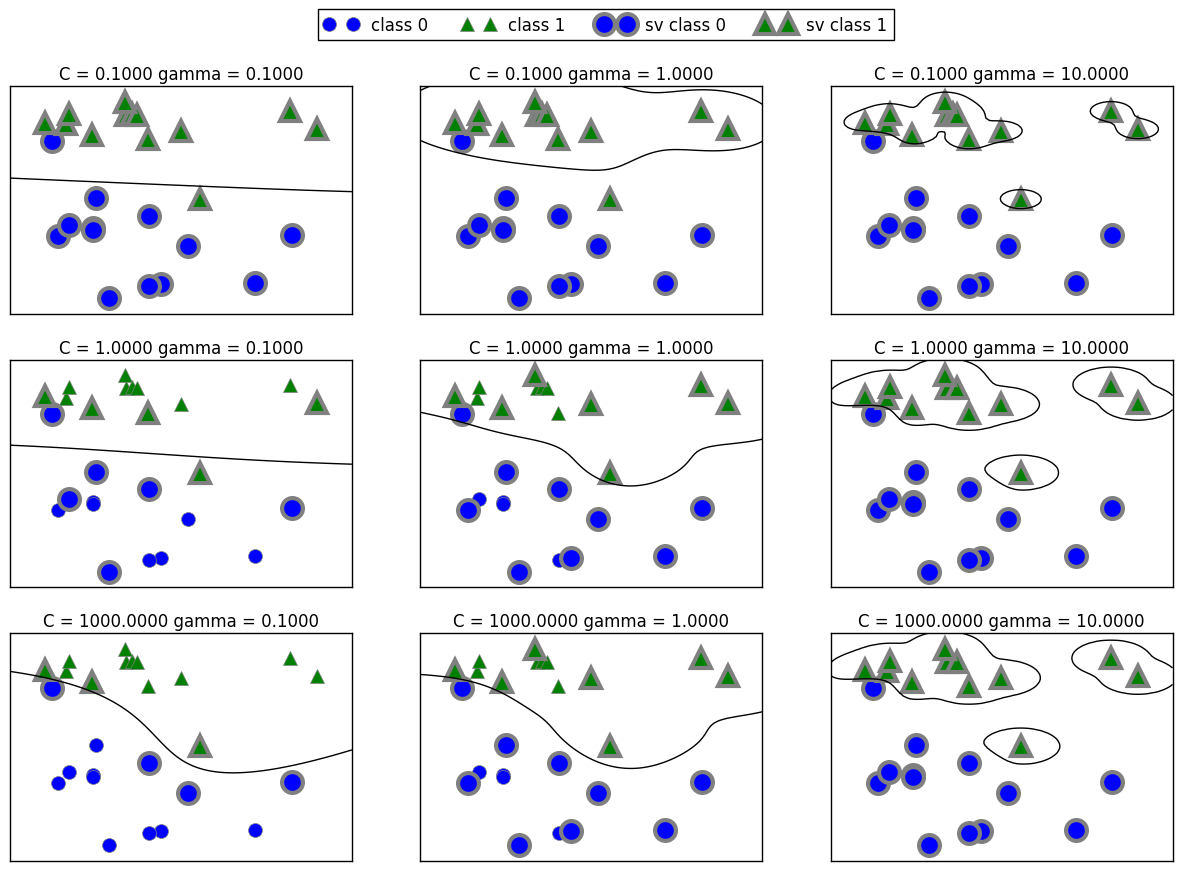

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"], ncol=4, loc=(0.9, 1.2))

Applying the RBF kernel SVM to the Breast Cancer dataset.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC().fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.63


The model overfits substantially. SVMs are very sensitive to the settings of the parameters.  In particular, they require all the features to vary on a similar scale.  Looking at the min-max values for each feature plotted in log-space:

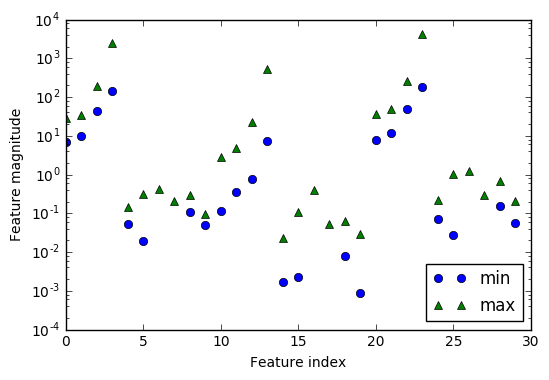

In [12]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

Pre-processing Data for SVMs
---

Rescale each feature so that they are all on the same scale.  Common is to force each value between 0-1.

In [17]:
min_on_training = X_train.min(axis=0)
range_on_training = (X_train - min_on_training).max(axis=0)

X_train_scaled = (X_train - min_on_training) / range_on_training
print("Min for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Max for each feature\n{}".format(X_train_scaled.max(axis=0)))

X_test_scaled = (X_test - min_on_training) / range_on_training

Min for each feature
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Max for each feature
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [20]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.948
Accuracy on test set: 0.951


Scaling the data made a huge difference.  To fix the underfitting, scale C or gamme to fit a more complex model.

In [21]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


Strengths, weaknesses, and parameters
---

Kernelized support vector machines allow for complex decision boundaries even if the data has few features.  They work well on low-dimensional and high-dimensional data, but don't scale very well with the number of samples.  10,000 samples may be fine, but 100,000 could cause challenges for runtime and memory.

SVMs require careful preprocessing of the data and tuning of the parameters.  This is why, these days, most opt for tree-based models like random forest or gradient boosting.  Furthermore, SVM models are hard to inspect.  It may be tricky to explain the model to a non-expert.

It may be worth trying SVMs if all your features represent measurements in similar units and they are all on the same scales.

The important parameters in kernel SVMs  are the regularization parameter C, the choice of the kernel, and the kernel-specific parameters.  Other kernel choices besides RBF are available in scikit-learn.

The RBF kernel has a single parameter, gamma, which is the inverse of the width of the Gaussian kernel.  Large values in either C or gamma will result in a more complex model.  Typically, C and gamma should be adjusted together.
